# 3.0a Cluster Analysis with Taxi Main DF

**Tasks**: Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods**: Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## Outline of this notebook:
1. Helper Functions
2. Adding Additional Features
3. Feature Selection
4. ...

In [1]:
# Hexagon resolution to work with for the rest of the notebook
RES = 8

In [75]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from collections import Counter
from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans


from sklearn.metrics import calinski_harabasz_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy

# progress bar
from tqdm import tqdm
tqdm.pandas()

In [76]:
## USER REQUIREMENTS TODOOOOOOoo
#pip install fastparquet pyarrow
# pip install statsmodels

In [3]:
# Color global palette
plt.rcParams['image.cmap'] = 'viridis'
sns.set_palette('viridis')

In [4]:
taxi_df = pd.read_parquet('data/prepped/prep_taxidata.parquet')

In [5]:
taxi_df.head(3)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,...,company_encoded,taxi_id_encoded,pickup_community,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.5,0.0,...,0,0,WEST RIDGE,2,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff
2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.0,2.0,...,1,1,NEAR NORTH SIDE,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff
3,38292159642750da7b20419330566f9eb0961cde,81092e4881f56106fae845c3ae4492f8b3c3213c33c920...,2022-12-31 23:45:00,2023-01-01 00:00:00,546.0,0.85,NaN,NaN,6.5,0.0,...,2,2,NEAR NORTH SIDE,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff


In [7]:
taxi_df.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2574851
dropoff_census_tract          2574851
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
1_hour_window                       0
1_hour_window_sin                   0
1_hour_window_cos                   0
4_hour_window                       0
4_hour_windo

## 1.0 Helper functions

### 1.1 Scaling + Feature Selection

In [9]:
def most_common_variables(arrays, n=8):
    all_variables = [item for sublist in arrays for item in sublist]
    most_common = Counter(all_variables).most_common(n)
    most_common_variables = [variable for variable, count in most_common]
    return most_common_variables

In [10]:
# Scaling
def scale_df(X):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)
    return pd.DataFrame(df_scaled, columns=X.columns, index=X.index)

In [11]:
# Feature Selection according to https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46
def optimize_feature_selection(df, maxvars=8, kmin=3, kmax=6):
    '''
    Input is sampled df (approx.  rows, else takes too long)
    Maximal number of variables we want to have 
    Minimum and maximum number of clusters for which we calculate the silhouette scores
    
    Returns the best cluster number and the most suitable variables for clustering
    '''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    results_for_each_k = []
    vars_for_each_k = {}
    
    kmeans_kwargs = {"init": "k-means++","n_init": 3,"random_state": 1984, "batch_size": 1000}
    
    for k in tqdm(range(kmin, kmax + 1), desc="Clusters"):
        selected_variables = []
    
        for _ in range(maxvars):
            scores = []
            for col in df.columns:
                if col not in selected_variables:
                    scols = selected_variables + [col]
                    kmeans = MiniBatchKMeans(n_clusters=k, **kmeans_kwargs) #use minibatchkmeans instead
                    kmeans.fit(df_scaled[:, [df.columns.get_loc(c) for c in scols]])

                    if len(np.unique(kmeans.labels_)) > 1:
                        score = silhouette_score(df_scaled[:, [df.columns.get_loc(c) for c in scols]], 
                                                 kmeans.labels_, sample_size=min(len(df), 10000)) #use sample size here
                        scores.append((col, score))
                    else:
                        scores.append((col, -1))

            if scores:
                best_col = max(scores, key=lambda x: x[1])[0]
                selected_variables.append(best_col)

        results_for_each_k.append(max(score for _, score in scores))
        vars_for_each_k[k] = selected_variables
    
    best_k = np.argmax(results_for_each_k) + kmin
    selected_variables = vars_for_each_k[best_k]
    
    kmeans = MiniBatchKMeans(n_clusters=best_k, **kmeans_kwargs)
    kmeans.fit(df_scaled[:, [df.columns.get_loc(c) for c in selected_variables]])
    #clusters = kmeans.predict(df_scaled[:, [df.columns.get_loc(c) for c in selected_variables]])
    
    return best_k, selected_variables #clusters

In [12]:
# Same function as above, only for GMM and BIC/AIC
def optimize_feature_selection_GMM(df_test_sample, maxvars=8, kmin=3, kmax=6):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_test_sample)
    
    results_for_each_k = []
    vars_for_each_k = {}
    
    gmm_kwargs = {"n_init": 10, "random_state": 1984}
    
    for k in tqdm(range(kmin, kmax + 1), desc="Gaussians"):
        cols = list(df_test_sample.columns)
        selected_variables = []
        
        for _ in range(maxvars):
            results_bic = []
            results_aic = []
            for col in cols:
                scols = selected_variables + [col]
                
                gmm = GaussianMixture(n_components=k, **gmm_kwargs)
                gmm.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]])
                
                bic = gmm.bic(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]])
                aic = gmm.aic(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in scols]])
                
                results_bic.append(bic)
                results_aic.append(aic)
            
            selected_var_bic = cols[np.argmin(results_bic)]
            selected_var_aic = cols[np.argmin(results_aic)]
            
            # Select the variable that appears more optimal in both BIC and AIC
            if selected_var_bic == selected_var_aic:
                selected_var = selected_var_bic
            else:
                selected_var = selected_var_bic if np.argmin(results_bic) < np.argmin(results_aic) else selected_var_aic
            
            selected_variables.append(selected_var)
            cols.remove(selected_var)
        
        gmm = GaussianMixture(n_components=k, **gmm_kwargs)
        gmm.fit(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
        
        bic = gmm.bic(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
        aic = gmm.aic(df_scaled[:, [df_test_sample.columns.get_loc(c) for c in selected_variables]])
        
        results_for_each_k.append((bic, aic))
        vars_for_each_k[k] = selected_variables
    
    # Determine the best k based on both BIC and AIC (here we use a combined metric approach)
    combined_results = [sum(x) for x in results_for_each_k]
    best_k = np.argmin(combined_results) + kmin
    selected_variables = vars_for_each_k[best_k]
    
    return best_k, selected_variables, results_for_each_k

In [78]:
# Heatmap for feature selection
def heatmap(scaled_dataframe, x=10, y=10):
    corr_matrix = scaled_dataframe.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(x, y))
    sns.heatmap(corr_matrix,
            mask = mask,
            annot=True, 
            cmap='viridis', 
            vmin=0, 
            vmax=1,
            linewidth=1, linecolor="w", square=True
           )
    plt.title('Feature Importances using Correlation-Matrix')
    plt.show()
    
    # Print the variables with high correlation
    threshold = 0.7
    high_corr_var = [(corr_matrix.index[i], corr_matrix.columns[j]) 
                 for i in range(len(corr_matrix.columns)) 
                 for j in range(i + 1, len(corr_matrix.columns)) 
                 if abs(corr_matrix.iloc[i, j]) > threshold]

    print("Variables with correlation greater than {}: \n".format(threshold))
    for var_pair in high_corr_var:
        print(var_pair)

### 1.2 PCA

In [13]:
# Dimensionality Reduction via PCA
def number_of_componentsPCA(X_scaled):
    pca = PCA()
    pca.fit(X_scaled)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

    plt.figure(figsize = (8,6))
    plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    
    plt.axhline(y=80, color='r', linestyle='-')
    
    plt.ylabel("Percentage Cumulative of Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("Explained Variance by Component")
    plt.show()

In [14]:
# Perform PCA 
def do_pca(X_scaled, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X_scaled)
    pca_result = pca.transform(X_scaled)
    
    important_features = pca.components_
    feature_names = X_scaled.columns
    important_features_df = pd.DataFrame(important_features.T, columns=[f'PC{i+1}' for i in range(important_features.shape[0])], index=feature_names)
    
    return pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]), important_features_df

### 1.3 Quality Metrics

In [97]:
# Grid search
def elbow_method(df_scaled, kmax=10):
    loss = []
    for k in tqdm(range(1, kmax+1)):
        km = KMeans(n_clusters=k,  n_init="auto", random_state=42)
        km.fit(df_scaled)
        loss.append(km.inertia_)

    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(1, kmax+1), loss, marker='o', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS Loss')
    plt.title('Elbow Method with K-Means++')
    plt.show()

In [96]:
# Plot BIC/AIC for GMM cluster number
def plot_aic_bic_gmm(df_scaled, kmax=30):
    bic_scores = []
    aic_scores = []
    
    for k in tqdm(range(1, kmax+1)):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gmm.fit(df_scaled)
        
        bic_scores.append(gmm.bic(df_scaled))
        aic_scores.append(gmm.aic(df_scaled))
    
    sns.lineplot(x=range(1, kmax+1), y=bic_scores, label='BIC')
    sns.lineplot(x=range(1, kmax+1), y=aic_scores, label='AIC')
    
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores for GMM')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [95]:
# Silhouette scores according to different cluster numbers
def plot_silhouette_scores(data, k_max):
    # 10000 rows only since computationally expensive else
    df_sampled = data.sample(n=10000, random_state=42)
    
    ncols = 3
    # calculate number of rows
    nrows = k_max // ncols + (k_max % ncols > 0)
    fig = plt.figure(figsize=(15,15), dpi=200)
    
    for k in tqdm(range(2, k_max+1)):
        km = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
        km_fit = km.fit(df_sampled)
    
        # Visualize
        ax = plt.subplot(nrows, ncols, k-1)
        silhouette_plot(df_sampled, km_fit, ax)
        
    fig.suptitle("Silhouette plots", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()

In [94]:
# Silhouette Plot for (works only for small sample else too computationally expensive!)
# Medium Best Practices for Visualizing Your Cluster Results
def silhouette_plot(X, model, ax):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    colors = sns.color_palette('viridis', model.n_clusters)
    
    ax.grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values, facecolor=colors[idx], edgecolor=colors[idx], zorder=2)
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    ax.legend(loc="best")
    return ax

Silhouette Score measures goodness of fit for different cluster numbers by (b-a)/max(a,b) where:
- b: average distance between all clusters
- a: average distance between each point within a cluster

The score is between [-1, 1], where
- -1 means clusters are assigned wrong
- 1 means clusters are well apart 
- 0 means cluster distance is not significant

(https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [161]:
# Visualize cluster representation by plotting magnitude and cardinality of clusters
def visualize_cluster_representative_power(df_original, df_scaled, cluster_col_name, model):
    fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(10, 8))
    
    axes = axes.flatten()
    
    axes[0].grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    axes[1].grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
    
    # 1. Plot cluster cardinality
    sns.countplot(df_original, x=cluster_col_name, hue=cluster_col_name, palette="viridis", ax=axes[0], zorder=2)
    axes[0].set_title('Cluster Cardinality')
    axes[0].set_xlabel('Cluster Label')
    axes[0].set_ylabel('Points in Cluster')
    axes[0].legend()
    
    ## 2. Plot cluster magnitudes
    dist = model.transform(df_scaled).sum(axis=1)
    df_magnitude = pd.DataFrame(dist.round(2), columns=['distance_to_cluster_center'])
    df_magnitude[cluster_col_name] = kmeans.labels_
    df_magnitude = df_magnitude.groupby(cluster_col_name).sum().reset_index()
    sns.barplot(x=cluster_col_name, y="distance_to_cluster_center", data=df_magnitude, palette="viridis", hue=cluster_col_name, ax=axes[1], zorder=2)
    
    axes[1].set_title('Cluster Magnitude')
    axes[1].set_xlabel('Cluster Label')
    axes[1].set_ylabel('Total Point-to-Centroid Distance')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

After clustering with the determined optimal number of clusters has been applied, you should have a look at the cluster results.
It is very useful to focus on properties such as:
- Cluster Cardinality: The cluster cardinality, or the cluster sizes, plot shows the number of points per cluster
- Cluster Magnitude: shows the total point to centroid distance per cluster. This chart can be used to see how high is the ‘spread’ of the points in each cluster and if there are any clumpy or wide clusters

4

### 1.3 Cluster Visuals

In [93]:
def violin_plots(df_prep, cluster_col, features_to_plot):
    num_features = len(features_to_plot)
    num_rows = (num_features // 2) + (num_features % 2)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    cluster_count = len(pd.unique(df_prep[cluster_col]))
    order_of_clusters = list(range(cluster_count))
    
    for i, feature in enumerate(features_to_plot):
        sns.violinplot(ax=axes[i], x=df_prep[cluster_col], y=df_prep[feature], order=order_of_clusters, hue=df_prep[cluster_col], palette="viridis")
        axes[i].set_title(feature.replace('_', ' ').title(), fontweight='bold')

    
    fig.tight_layout()
    plt.show()

In [23]:
## Evaluation measures
#def evaluate_clustering(data, cluster_col):
    

## 2.0 Adding Additional Features 
You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.

In [18]:
taxi_add_features = taxi_df.copy()

### 2.0.1 Temporal Features

In [19]:
# Get weekday or not (0 if not, 1 if it is)
#taxi_add_features['is_weekday'] = (taxi_df["weekday"] < 5).astype(int)

### 2.0.2 Distance to city center

In [20]:
# City center = hexagon with the most pickups
center_hex = taxi_df[f'h3_res{RES}_pickup'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')
taxi_add_features[taxi_add_features[f'h3_res{RES}_pickup'] == center_hex].iloc[0].pickup_community

Center hexagon: 882664c1edfffff


'NEAR NORTH SIDE'

In [21]:
# Calculate grid distances
def calculate_h3_grid_distances(df, center_hex):
    df[f'dist_from_center_pickup'] = df[f'h3_res{RES}_pickup'].apply(lambda x: h3.h3_distance(x, center_hex))
    df[f'dist_from_center_dropoff'] = df[f'h3_res{RES}_dropoff'].apply(lambda x: h3.h3_distance(x, center_hex))
    
    return df

In [22]:
taxi_add_features = calculate_h3_grid_distances(taxi_add_features, center_hex)

### 2.0.3 Trip Direction

If we are moving towards the center, then the direction (distance between pickup and dropoff) is positive, whereas moving away from the city center gives us a negative distance

In [23]:
# Get the direction of the trip
taxi_add_features['moving_towards_center'] = taxi_add_features['dist_from_center_pickup'] - taxi_add_features['dist_from_center_dropoff'] 

In [24]:
taxi_add_features[taxi_add_features['moving_towards_center'] < 0].head(3)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,...,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
6,32c54ad25f76c07b29bc59b04f9f196cf811ed67,cb1a522e6e968cbebb7ce23e6775a4769de4aeb2154fa5...,2022-12-31 23:45:00,2023-01-01 00:00:00,876.0,8.91,NaN,NaN,23.75,0.00,...,33,AUBURN GRESHAM,71,872664c1bffffff,872664cd8ffffff,882664c1b5fffff,882664cd89fffff,6,23,-17
8,3186be22cdd5d17def50e44eca6be9ec9b0a9974,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2022-12-31 23:45:00,2022-12-31 23:45:00,540.0,0.70,1.703108e+10,1.703184e+10,7.25,0.00,...,8,LOOP,32,872664c1effffff,872664c1affffff,882664c1e7fffff,882664c1a9fffff,2,3,-1
9,3173e055e640d8202bb39f25d59eb46559ee8921,86b07dc8beb256766f2025da2b99b77345074852eabbdf...,2022-12-31 23:45:00,2023-01-01 00:15:00,1382.0,8.20,NaN,NaN,24.50,6.25,...,32,EDGEWATER,77,872664c1affffff,872664d88ffffff,882664c1a9fffff,882664d88bfffff,3,11,-8


### 2.0.4 Drop Redundancy

For our original dataframe which we will later use for visualization, we drop columns that are redundant with others and offer no further insight as these columns are represented already in encoded form. We also drop categorical which we may add later back in.

In [172]:
columns_to_drop = ['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
                   'trip_hours',
                   'pickup_census_tract', 'dropoff_census_tract', 
                   'payment_type', 'company', 
                   'pickup_centroid_location', 
                   'dropoff_centroid_location',
                   "dropoff_community", "pickup_community",
                   "h3_res7_dropoff", "h3_res7_pickup", "h3_res8_dropoff", "h3_res8_pickup",
                   'company_encoded',
                   'taxi_id_encoded',
                  ]

In [170]:
# Create df for visualizations AFTER clustering
original_features_df = taxi_add_features.drop(columns_to_drop, axis=1).copy()

For the dataframe on which we will later perform the clustering, we want to first prepare it for the next step of feature selection. This means that we will have to drop any trivial column (knowing the domain) that probably will not contribute to cluster formation. 
Columns that were dropped and why:
- Dropped trip_id, **DROP encoded_taxi_id TODOOOOOOOOOOOOOO** and taxi_id: they were identified as non-contributory to the customer groups, adding no value
- Dropped any already encoded columns or such which were available in more granular form i.e. sin/cos representations
- Dropped columns with detailed geographical such as location as we have lat/lng given
- Dropped non string column dropoff/pickup_community as encoded column given (area_number)
- Dropped census_tract since available in other forms and to avoid missing data

In [171]:
columns_to_drop.extend(['1_hour_window','4_hour_window','6_hour_window'])

In [119]:
# Create df for clustering, remove non-numerical columns
prep_df = taxi_add_features.drop(columns_to_drop, axis=1).copy()
prep_df.head()

,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,...,6_hour_window_cos,weekday,weekday_sin,weekday_cos,payment_type_encoded,pickup_area_number,dropoff_area_number,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
0,2081.0,4.42,20.50,0.0,0.0,0.0,20.50,42.001571,-87.695013,41.965812,...,-1.836970e-16,5,-0.974928,-0.222521,0,2,3,13,8,5
2,600.0,0.90,7.00,2.0,0.0,3.0,12.00,41.899602,-87.633308,41.899602,...,-1.836970e-16,5,-0.974928,-0.222521,1,8,8,0,0,0
3,546.0,0.85,6.50,0.0,0.0,0.0,6.50,41.899602,-87.633308,41.899602,...,-1.836970e-16,5,-0.974928,-0.222521,2,8,8,0,0,0
4,574.0,0.33,6.25,0.0,0.0,0.0,6.25,41.899602,-87.633308,41.899602,...,-1.836970e-16,5,-0.974928,-0.222521,2,8,8,0,0,0
5,1018.0,6.12,18.25,0.0,0.0,0.0,18.25,41.744205,-87.656306,41.761578,...,-1.836970e-16,5,-0.974928,-0.222521,0,71,43,23,19,4


### 2.0.5 Drop Multi-Collinearity

Next we want to take a look at the similarities between features in order to avoid multi-collinearity. For this, we first visualize the current features using a dendogram and a heatmap.

In [64]:
# Standardize features
df_scaled = scale_df(prep_df)

In [65]:
# Get correlations
corr_matrix = df_scaled.corr()

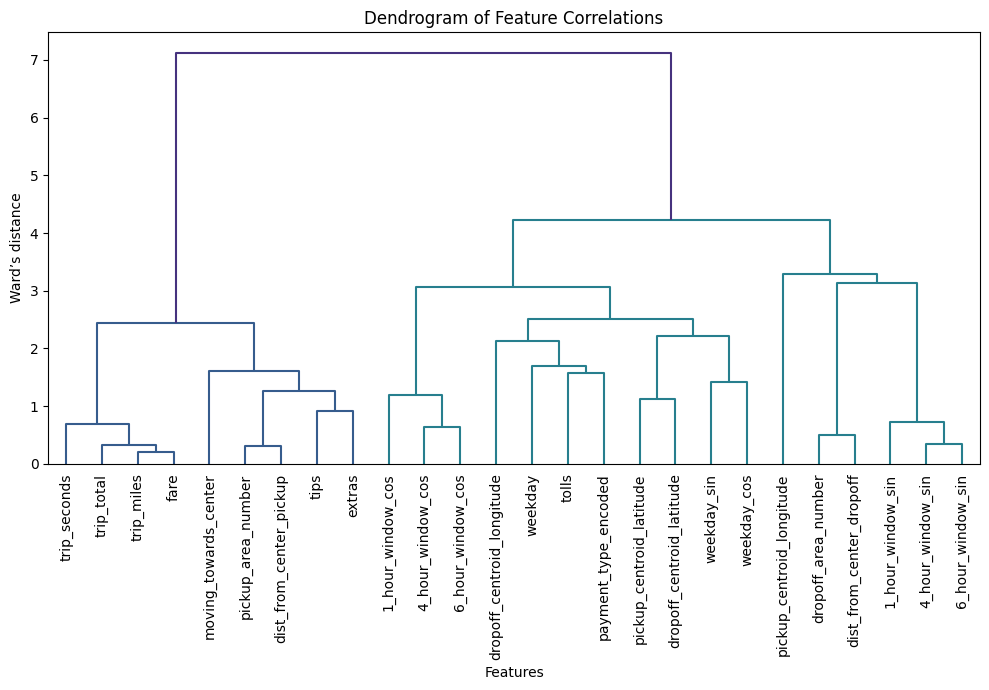

In [66]:
# Create dendogram
plt.figure(figsize=(10, 7))

linked= hierarchy.linkage(corr_matrix, method='ward')
dendrogram = hierarchy.dendrogram(linked, labels=corr_matrix.columns, leaf_rotation=90)

plt.xlabel('Features')
plt.ylabel('Ward’s distance')
plt.title('Dendrogram of Feature Correlations')
plt.tight_layout()
plt.show()

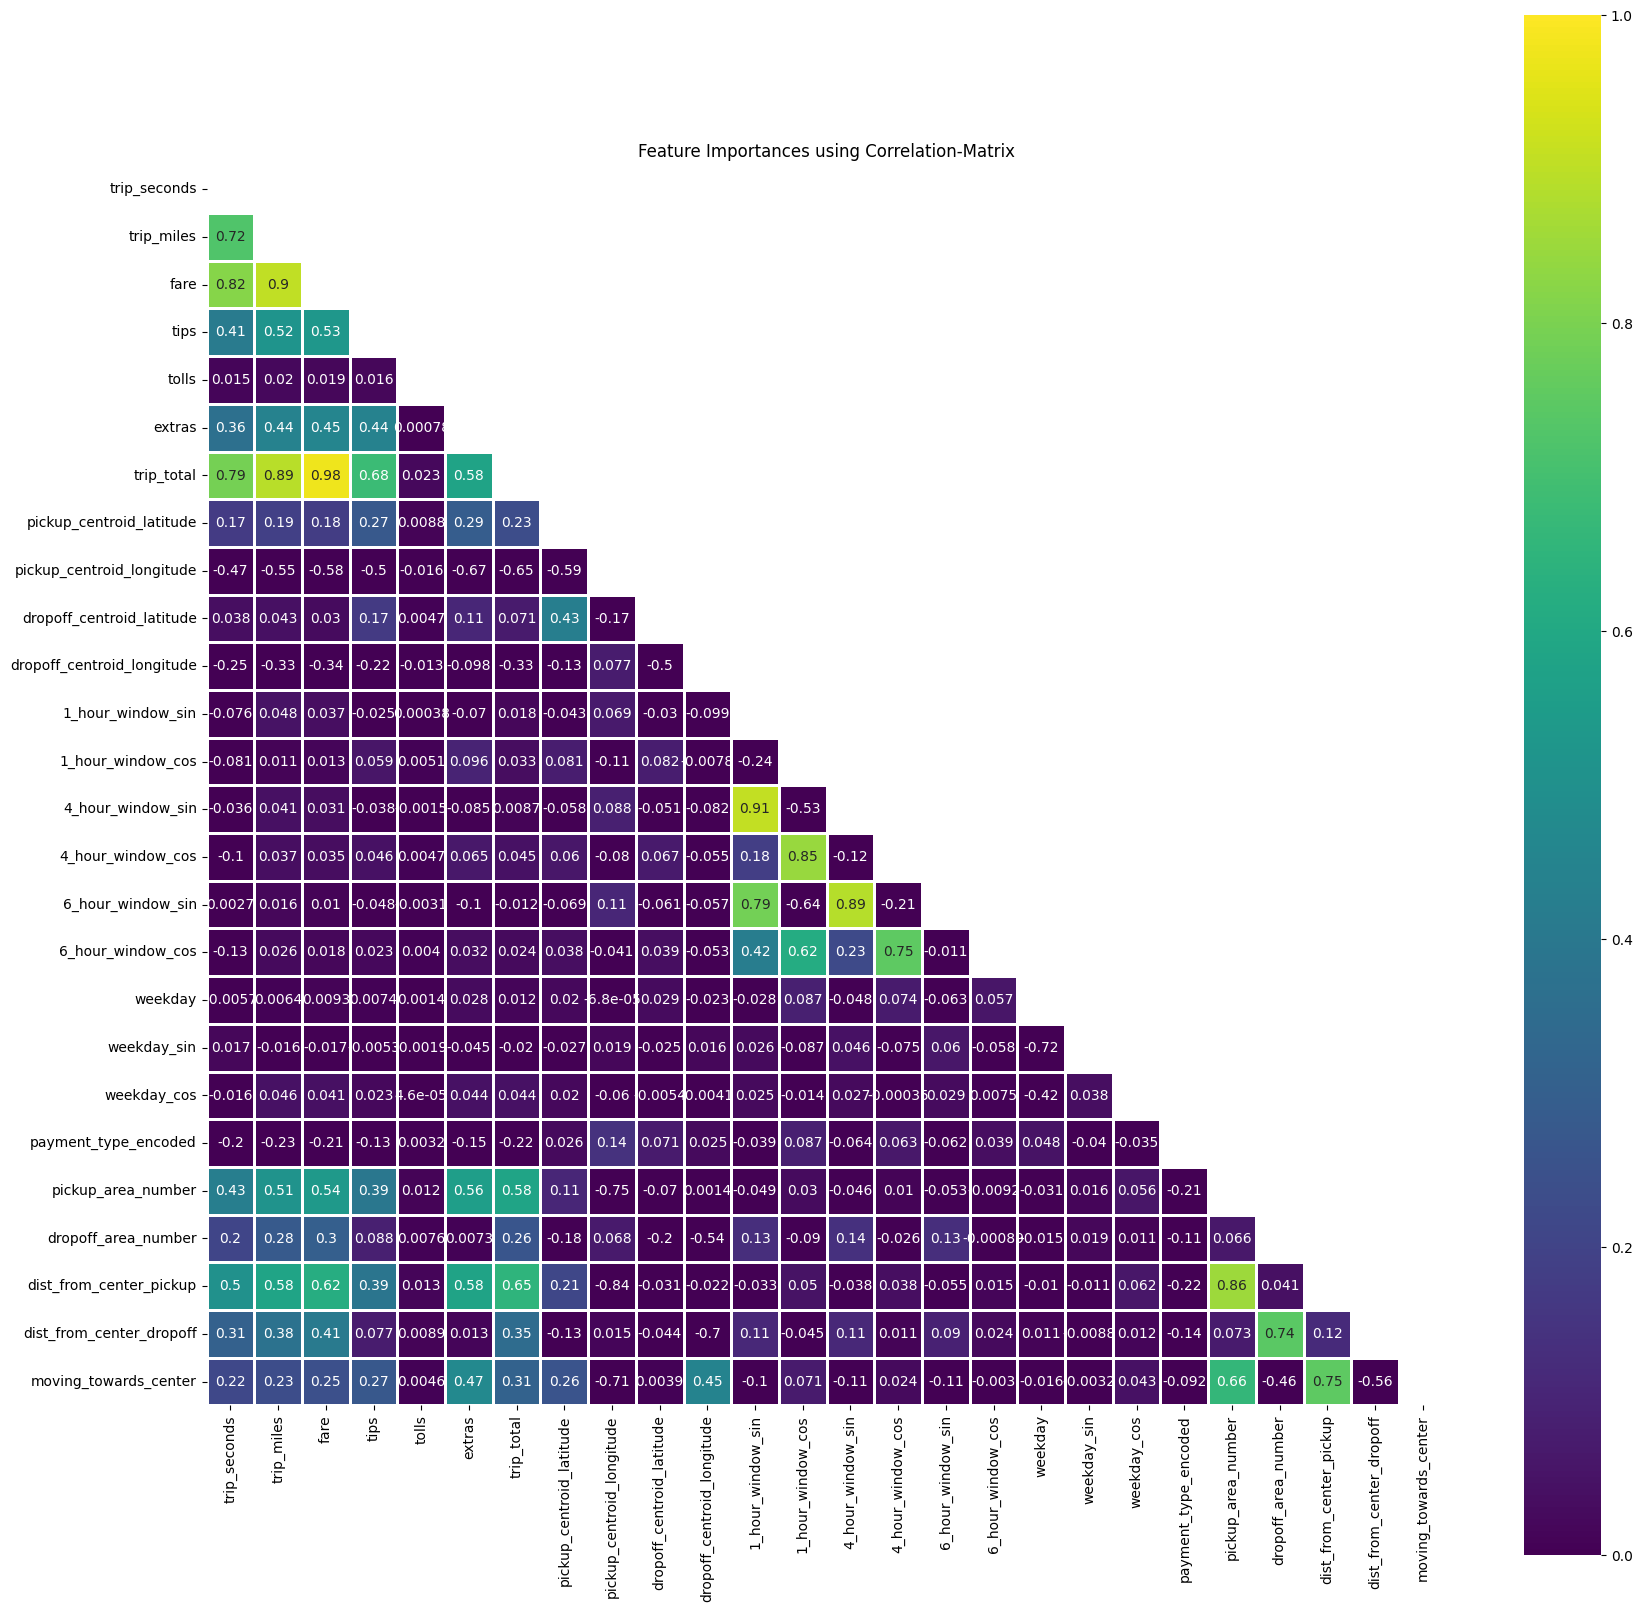

Variables with correlation greater than 0.7: 

('trip_seconds', 'trip_miles')
('trip_seconds', 'fare')
('trip_seconds', 'trip_total')
('trip_miles', 'fare')
('trip_miles', 'trip_total')
('fare', 'trip_total')
('pickup_centroid_longitude', 'pickup_area_number')
('pickup_centroid_longitude', 'dist_from_center_pickup')
('pickup_centroid_longitude', 'moving_towards_center')
('dropoff_centroid_longitude', 'dist_from_center_dropoff')
('1_hour_window_sin', '4_hour_window_sin')
('1_hour_window_sin', '6_hour_window_sin')
('1_hour_window_cos', '4_hour_window_cos')
('4_hour_window_sin', '6_hour_window_sin')
('4_hour_window_cos', '6_hour_window_cos')
('weekday', 'weekday_sin')
('pickup_area_number', 'dist_from_center_pickup')
('dropoff_area_number', 'dist_from_center_dropoff')
('dist_from_center_pickup', 'moving_towards_center')


In [79]:
# Heatmap for further correlation info
heatmap(df_scaled, x=20, y=20)

We observe a few highly correlated features. To avoid the risk of multi-collinearity we decide the following for these pairs:
- trip_seconds and trip_miles we keep as is, the correlation seems natural
- trip_total and fare are common denominators for high correlation and have themselves high correlation -> we drop fare
- longitudes are highly correlated with area number, calculated dist. features and the direction feature -> we drop the longitudes since they marginally change and the other two features are more telling
- sin/cos has obvious high correlation, we decide to keep only one representation -> cos since ward's distance larger to other features
- correlation between the area number and dist. features are redundant -> we only keep dist. features

In [120]:
to_drop = [ 
    'fare', 'tolls', 'tips', 'extras',
    '1_hour_window_sin',
    '4_hour_window_sin', '4_hour_window_cos', 
    '6_hour_window_sin', '6_hour_window_cos',
    'weekday',  "weekday_sin",
    'pickup_area_number', 'dropoff_area_number',
    'dropoff_centroid_longitude', 'pickup_centroid_longitude',
]
df_features = prep_df.drop(to_drop, axis=1).copy()
df_features.shape

(4739665, 11)

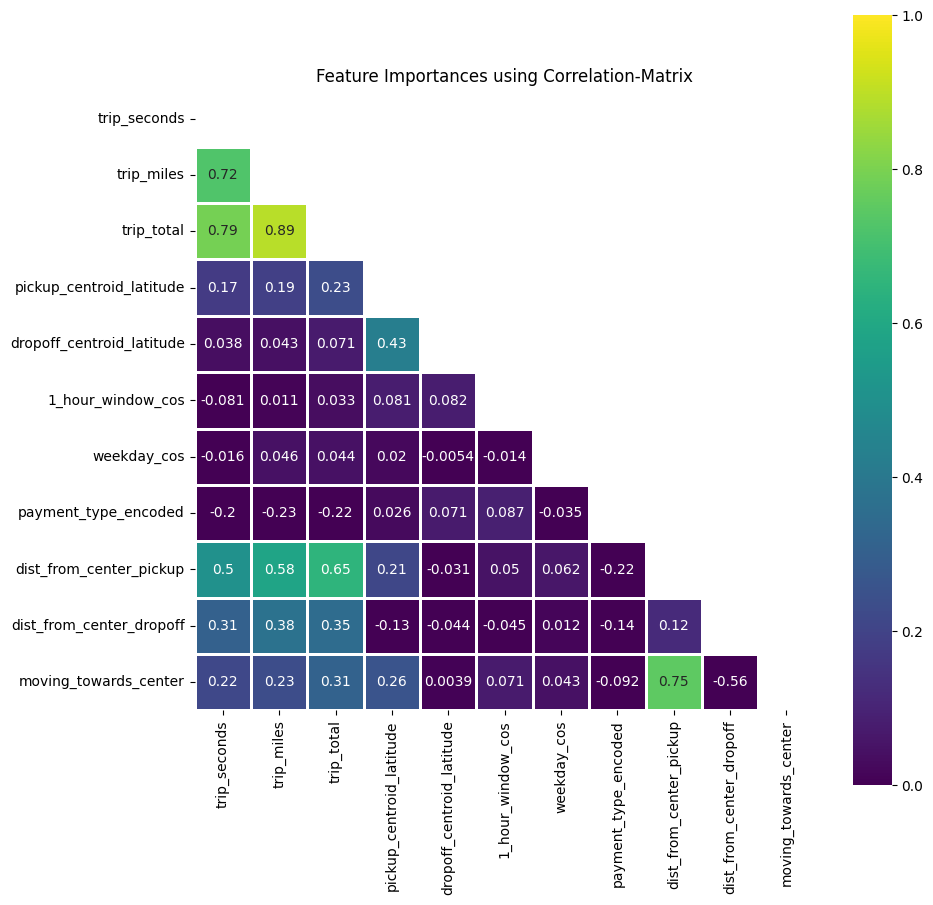

Variables with correlation greater than 0.7: 

('trip_seconds', 'trip_miles')
('trip_seconds', 'trip_total')
('trip_miles', 'trip_total')
('dist_from_center_pickup', 'moving_towards_center')


In [121]:
heatmap(df_features)

In [122]:
original_features_df.shape

(4739665, 31)

In [123]:
df_features.shape

(4739665, 11)

## 3.0 Clustering

### 3.1 K-means++

#### 3.1.1 Feature Selection

In [124]:
df_features.columns

Index(['trip_seconds', 'trip_miles', 'trip_total', 'pickup_centroid_latitude',
       'dropoff_centroid_latitude', '1_hour_window_cos', 'weekday_cos',
       'payment_type_encoded', 'dist_from_center_pickup',
       'dist_from_center_dropoff', 'moving_towards_center'],
      dtype='object')

In [85]:
# Run Feature Selection algorithm
best_k, selected_variables = optimize_feature_selection(df_features)
print("Best k:",best_k,"\nSelected Variables:",selected_variables)

Clusters: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [11:21<00:00, 170.31s/it]


Best k: 3 
Selected Variables: ['weekday_cos', 'dist_from_center_pickup', 'moving_towards_center', 'trip_total', 'trip_miles', 'dist_from_center_dropoff', 'dropoff_centroid_latitude', 'trip_seconds']


In [87]:
# LAST RUN:
#['weekday_cos', 'dist_from_center_pickup', 'moving_towards_center', 'trip_total', 'trip_miles', 'dist_from_center_dropoff', 'dropoff_centroid_latitude', 'trip_seconds']
#last last 'weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'dropoff_centroid_longitude', 'trip_total', 'moving_towards_center', 'trip_miles', 'dist_from_center_dropoff'

In [125]:
df_common_features = df_features[selected_variables]

#### 3.1.2 Number of Clusters

In [89]:
# Standardize features
df_features_scaled = scale_df(df_common_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.60s/it]


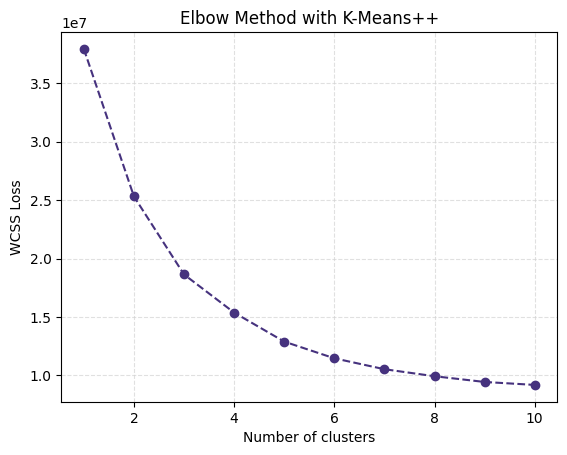

In [90]:
# Use elbow method to get number of clusters
elbow_method(df_features_scaled)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.61s/it]


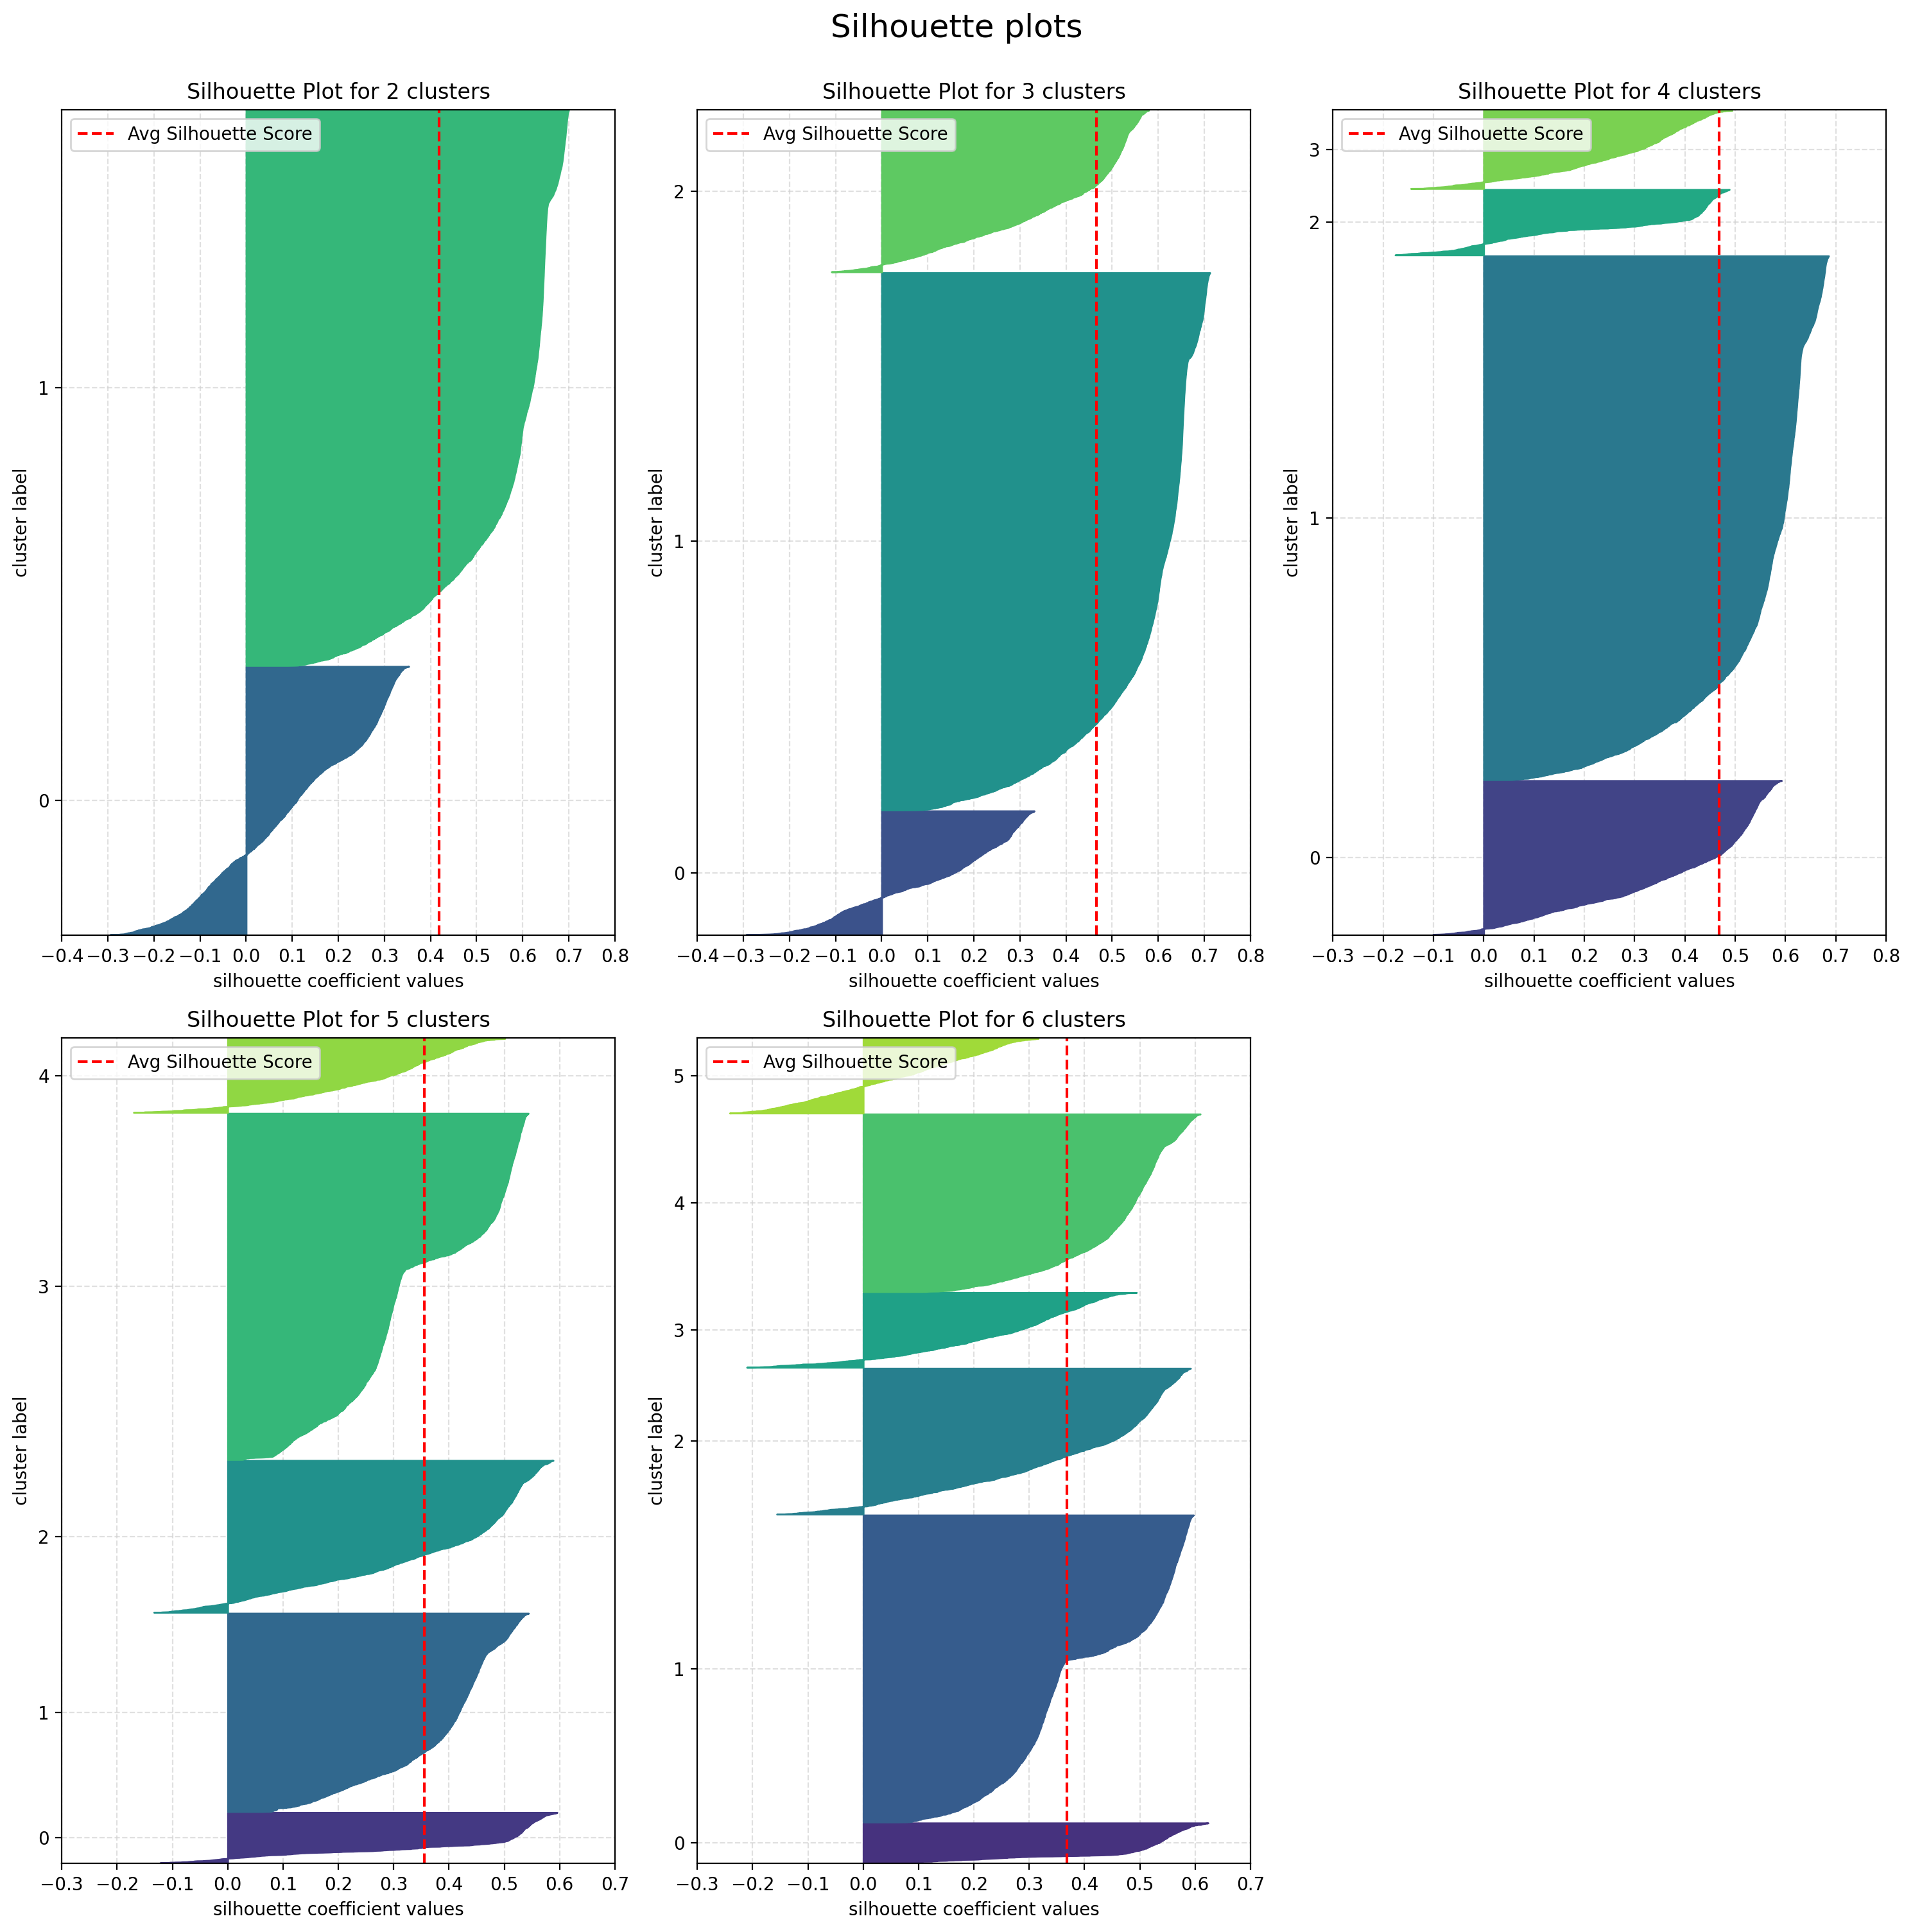

In [98]:
# Verify elbow method using silhouette scores
plot_silhouette_scores(df_features_scaled, 6)

Based on the curve, we can see that the curve is smoothed from point "Number of cluster" = 4, indicating our elbow point. We additionally verify these results by comparing silhouette scores of kmeans++ for different cluster numbers. This, however, is only done for a small sample of the original dataframe **(10.000 entries)** since else silhouette scores are very computationally expensive to compute. We can see similar results for a cluster number of 4.  

In [99]:
# Set the max number of clusters for the following tasks
CLUSTER_NUMBER = 4

#### 3.1.3 Running K-means++

In [173]:
# Run kmeans++ (10 iterations)
kmeans = KMeans(init="k-means++", n_clusters = CLUSTER_NUMBER, n_init=10)

In [174]:
original_features_df['cluster_kmeans++'] = kmeans.fit_predict(df_features_scaled)

In [ ]:
visualize_cluster_representative_power(
    original_features_df,
    df_features_scaled,
    cluster_col_name="cluster_kmeans++", 
    model=kmeans)

While usually it is best for the representative power of the clusters to be of similar size, this might be explainable through furhter analysis. 

In [176]:
original_features_df.columns

Index(['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
       '1_hour_window', '1_hour_window_sin', '1_hour_window_cos',
       '4_hour_window', '4_hour_window_sin', '4_hour_window_cos',
       '6_hour_window', '6_hour_window_sin', '6_hour_window_cos', 'weekday',
       'weekday_sin', 'weekday_cos', 'payment_type_encoded',
       'pickup_area_number', 'dropoff_area_number', 'dist_from_center_pickup',
       'dist_from_center_dropoff', 'moving_towards_center',
       'cluster_kmeans++'],
      dtype='object')

In [ ]:
cluster_means = original_features_df.groupby(['cluster_kmeans++']).mean().T

In [ ]:
# What characteristic represents each cluster the most? 
cluster_means

We observe for each cluster: - --- TODO DONT RUN BEFORE ELSE RENUMBER_____________________________---

Cluster 0
- Moderate trip duration and distance
- Moderate trip total
- Pickup and dropoff locations are moderately far from the city center, pickup location is second most far out
- Moving towards the center

Cluster 1
- Shortest trip duration and distance (miles)
- Lowest trip total
- Pickup and dropoff locations close to another
- Moving on average slightly away from center

Cluster 2
- Longest trip durations and distance
- Highest trip total
- Pickup location farthest away from city center, dropoff close to center
- Moving towards center

Cluster 3
- Long trip duration and distance, similar to Cluster 2
- High trip total
- Pickup locations are central, dropoff locations are farthest from center
- Moving away from the center.


In [ ]:
# Calculate the relative differences 
overall_mean = cluster_means.T.mean()
relative_differences = cluster_means.copy()

for cluster in cluster_means.columns:
    relative_differences[cluster] = (overall_mean - cluster_means[cluster] ) / overall_mean

relative_differences

In [ ]:
transposed_rd = relative_differences.T
transposed_rd.shape

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,15))

colors = sns.color_palette('viridis', CLUSTER_NUMBER)

axes = axes.flatten()

for i, cluster in enumerate(transposed_rd.columns):
    axes[i].barh(transposed_rd.index, transposed_rd[cluster], color=colors, label=f'Cluster {cluster}')
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_ylabel('Relative Difference')


legend_patches = [mpatches.Patch(color=colors[i], label=f'cluster {i}') for i in range(CLUSTER_NUMBER)]
fig.legend(handles=legend_patches, title="Overview of cluster characteristics", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=CLUSTER_NUMBER, fontsize=12)

plt.tight_layout()
plt.xlabel('Features')
plt.show()

In [ ]:
# Transpose for easier plotting
relative_differences.T

# Angle of axis = plot / number of variable
angles = [n / float(len(relative_differences.index)) * 2 * np.pi for n in range(len(relative_differences.index))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = sns.color_palette('viridis', len(relative_differences.columns))

for i, cluster in enumerate(relative_differences.columns):
    values = relative_differences[cluster].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}", color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])


plt.xticks(angles[:-1], relative_differences.index)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
df_original_features.columns

In [ ]:
features_to_plot = ['trip_seconds', 'trip_miles', 'trip_total', '1_hour_window_cos', 'moving_towards_center', 'dist_from_center_pickup', 'dist_from_center_dropoff', 'weekday_cos', 'pickup_area_number']
violin_plots(df_original_features, "cluster_kmeans++", features_to_plot)

#### 3.1.4 K-means++ with PCA

In [ ]:
number_of_componentsPCA(df_common_features)

In [ ]:
# To preserve ~80% of the variance pick 2
PCA_COMPONENTS_KMEANS = 2

In [ ]:
pca_result_df, important_features_df = do_pca(df_features_scaled, PCA_COMPONENTS_KMEANS)

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(important_features_df.shape[1]):
    plt.bar(important_features_df.index, important_features_df.iloc[:, i], label=f'PC{i+1}', zorder=2)

plt.xlabel('Features')
plt.ylabel('COmopnent Score')
plt.title('PCA Components by their importance for each component')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey', zorder=1)
plt.tight_layout()
plt.show()

In [ ]:
elbow_method(pca_result_df)

In [ ]:
# Elbow at 3~4, first pick 3
CLUSTER_NUM_PCA = 3

In [ ]:
# kmeans++ with PCA 
kmeans_pca = KMeans(n_clusters = CLUSTER_NUM_PCA, n_init=10)
kmeans_pca.fit(pca_result_df)
pca_result_df["cluster_kmeans++_pca"] = kmeans_pca.labels_

In [ ]:
df_original_features_pca = pd.concat([original_features_df, pca_result_df], axis=1, join="inner")
df_original_features_pca

In [ ]:
#visualize_cluster_representative_power(original_df=df_original_features_pca, cluster_col_name="cluster_kmeans++_pca", model=kmeans_pca)

In [ ]:
sample_df = df_original_features_pca.sample(n=10000)

In [ ]:
x_axis= sample_df["PC2"]
y_axis=  sample_df["PC1"]
plt.figure(figsize=(10,8))
sns.scatterplot(data=sample_df, x=x_axis, y=y_axis, hue=sample_df["cluster_kmeans++_pca"])
plt.show()

In [ ]:
ax = plt.axes(projection='3d')

plt.figure(figsize=(10,8))
ax.scatter3D(sample_df["weekday_cos"], sample_df["dist_from_center_pickup"], sample_df["trip_total"], c=sample_df["cluster_kmeans++_pca"]);
plt.show()

In [ ]:
sample_df.columns

In [ ]:
features_to_plot = ['trip_seconds', 'trip_miles', 'trip_total', '1_hour_window', '4_hour_window', '6_hour_window', 'moving_towards_center', 'dist_from_center_pickup', 'dist_from_center_dropoff', 'is_weekday', 'weekday']

In [ ]:
violin_plots(df_original_features_pca, 'cluster_kmeans++_pca', features_to_plot)

### 3.2 Gaussian Mixture Model

#### 3.2.1 Feature Selection

In [ ]:
all_selected_variables = []
best_k_all = []

for i in tqdm(range(0, 5), desc="Sampling"):
    df_test_sample = df_features.sample(n=3000)
    best_k, selected_variables = optimize_feature_selection_GMM(df_test_sample)
    best_k_all.append(best_k)
    all_selected_variables.append(selected_variables)

In [ ]:
print("k:",best_k_all,"\nvariables:",all_selected_variables)
common_selected_var = most_common_variables(all_selected_variables, n=8) 
common_selected_var
# LAST RUN: ['weekday_cos', 'pickup_centroid_longitude', 'dist_from_center_pickup', 'pickup_centroid_latitude', 'pickup_area_number', 'moving_towards_center', 'dist_from_center_dropoff', 'trip_total']

In [ ]:
df_common_features_gmm = df_features[common_selected_var]

In [ ]:
number_of_componentsPCA(df_common_features_gmm)

#### 3.2.1 Number of Gaussians

In [ ]:
# Standardize features
df_features_scaled_gmm = scale_df(df_common_features_gmm)

In [ ]:
plot_aic_bic_gmm(df_features_scaled_gmm.sample(n=10000))

We generally pick the number according to the lowest BIC/AIC values. However, as there is a significant increase in score decrease after ca. 6 clusters, we pick 6 as the cluster number. 

In [ ]:
CLUSTER_NUMBER_GMM = 6

#### 3.1.3 Running GMM

In [ ]:
gmm = GaussianMixture(n_components=CLUSTER_NUMBER_GMM)
df_original_features['cluster_gmm'] = gmm.fit_predict(df_features_scaled_gmm)

In [ ]:
visualize_cluster_representative_power(original_df=df_original_features, df_scaled=df_features_scaled_gmm, cluster_col_name="cluster_gmm", model=gmm)

In [ ]:
# What characteristic represents each cluster the most? 
cluster_means = df_original_features.groupby(['cluster_gmm']).mean().T
cluster_means

In [ ]:
# Calculate the relative differences 
overall_mean = cluster_means.T.mean()
relative_differences = cluster_means.copy()

for cluster in cluster_means.columns:
    relative_differences[cluster] = (overall_mean - cluster_means[cluster] ) / overall_mean

relative_differences

In [ ]:
# Transpose for easier plotting
relative_differences.T

# Angle of axis = plot / number of variable
angles = [n / float(len(relative_differences.index)) * 2 * np.pi for n in range(len(relative_differences.index))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = sns.color_palette('viridis', len(relative_differences.columns))

for i, cluster in enumerate(relative_differences.columns):
    values = relative_differences[cluster].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}", color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])


plt.xticks(angles[:-1], relative_differences.index)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
do

## 4.0 PCA

In [ ]:
number_of_componentsPCA(df_features_scaled)

After making the subsets with corresponding features, the dataframe df_geo_f has more than 4 features. For this, we want to take a look to reduce the amount via dimensionality reduction. But first we use the algorithm provided by...:_TODOOO

To decide on features for which we want to cluster, we thought about task relevant features but also tested around with an algorithm provided by https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46.

Interesting Observations we can make from this:
- dist_from_center_pickup and trip_total as well as trip_miles
- pickup_area_number has similarly high correlations with trip_totla and trip_miles
- moving_towards_center has high correlation with pickup_area_number

In [ ]:
# Initalize globally
PCA_COMPONENTS = 4

In [ ]:
# Additionally reduce dim with PCA
pca_scaling = PCA(n_components=PCA_COMPONENTS)
pca_scaling_result = pca_scaling.fit_transform(df_selection_scaled)
explained_variance_scaling = pca_scaling.explained_variance_ratio_

In [ ]:
pca_components_df = pd.DataFrame(pca_scaling.components_, columns=df_selection.columns, index=['PC-1', 'PC-2', 'PC-3', 'PC-4']).T
for column in pca_components_df.columns:
    print(f"\nFeatures with high correlation for {column}: ")
    for index, value in pca_components_df[column].items():
        if np.abs(value) > 0.4:
            print(f"{index}: {value}")
            
pca_components_df

In [ ]:
# Plot the explained variance ratios
plt.figure(figsize=(6, 5))
colors = sns.color_palette('viridis', PCA_COMPONENTS)
for i in range(0, PCA_COMPONENTS):
    plt.barh(df_selection.columns, pca_scaling.components_[i], label=f'PC-{i+1}', color=colors[i])

plt.title('Features with their highest PCA value')
plt.legend()
plt.show()

For each PCA Component we can see that:
- PC-1: trip_miles increases so does trip_total,...

### 3.3 Clustering with kmeans++ and GMM

In [ ]:
df_cluster = df_selection.copy()

In [ ]:
# Run kmeans++ (10 iterations)
kmeans = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10)
df_cluster['cluster_kmeans++'] = kmeans.fit_predict(df_selection_scaled)

In [ ]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_cluster, 'cluster_kmeans++', kmeans.cluster_centers_, df_selection_scaled)

In [ ]:
# kmeans++ with PCA 
kmeans_pca = KMeans(n_clusters = CLUSTER_NUMBER, n_init=10)
kmeans_pca.fit(pca_scaling_result)
cluster_labels = kmeans_pca.labels_

# Create a DataFrame from the PCA results
pca_df = pd.DataFrame(pca_scaling_result, columns=[f'PC{i+1}' for i in range(pca_scaling_result.shape[1])])
pca_df["cluster_kmeans++"] = kmeans_pca.labels_

visualize_cluster_representative_power(CLUSTER_NUMBER, pca_df, "cluster_kmeans++",kmeans_pca.cluster_centers_,pca_scaling_result)

In [ ]:
# Run Gaussian Mixture Model
gmm = GaussianMixture(n_components = CLUSTER_NUMBER)
gmm.fit(df_selection_scaled)
df_selection["cluster_gmm"] = gmm.predict(df_selection_scaled)

In [ ]:
visualize_cluster_representative_power(CLUSTER_NUMBER, df_selection, 'cluster_gmm', kmeans.cluster_centers_, df_selection_scaled)

In [ ]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()